# Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy.stats import t
from scipy.stats import f
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import OrdinalEncoder

import seaborn as sns
from collections import Counter

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Kamatz project

**Research question. 
Name the topic & which questions you aim to answer (1-2 paragraphs).**

We are going to analyze the determinants of pricing in Kamatz. We build a regression model using the following features:
*  years of experience
*  number of skills
*  number of recommendations
*  ethnicity (arab, white, arab, asian, black, hispanic)
*  gender


We aim to understand, through the analysis of the regression model, what are the most important features determining the tariff of freelancers. 
Furthermore the aim of the analysis is to see if there are differences among the different ethnicities , so that maybe those that may suffer from discrimination have incentives to provide more information. We also inspect discrimination between male and female.
Similarly, we study the determinant of ranking of Kamatz to analyze if the platform’s algorithm has discriminatory behaviors. 



## Download data

In [2]:
url = 'https://raw.githubusercontent.com/RiccardoPrestigiacomo-99/analyse_kam/main/all.csv'
df = pd.read_csv(url, sep = ',')
df.head(5)

,name,id,location,title,experience,skills,nb_skills,tarif,recommendations,path_to_profile,skills_count,languages,isEducationListed,months_experience,num_experiences,searched_job,search_rank,fetched_at,region,sub-region,ethnicity,gender
0,Saker Kadri,bc5mh7ud4sc8,"Tunis, Tunisie",Administrateur bases de données,3 à 7 ans d'expérience,"['Microsoft Excel', 'Microsoft PowerPoint', 'S...",5,20€,0,/fr/freelance/saker-kadri,5,"[{'level': 5, 'lang': 'en'}, {'level': 5, 'lan...",False,0,0,Administrateur Base de Données,1,2022-01-05 20:05:10.382447,Africa,Northern Africa,asian,male
1,Joffrey Michaïe,xj3yn4yg0es7,"Paris, France",Consultant Bases de données,plus de 7 ans d'expérience,"['MySQL', 'MariaDB', 'Galera', 'Percona', 'Lin...",6,2400€,0,/fr/freelance/joffrey-michaie,6,"[{'level': 5, 'lang': 'en'}, {'level': 5, 'lan...",False,0,0,Administrateur Base de Données,2,2022-01-05 20:05:10.866183,Europe,Western Europe,white,male
2,MARTER,gv2bs7iy5gy2,"Bischheim, France",SECRÉTAIRE ASSISTANT - ADMINISTRATEUR WEB,3 à 7 ans d'expérience,"['accueil téléphonique', 'Word', 'Excel', 'Sec...",17,200€,0,/fr/freelance/marter,17,"[{'level': 2, 'lang': 'en'}]",True,0,0,Administrateur Base de Données,3,2022-01-05 20:05:11.303683,Europe,Western Europe,white,male
3,MAALAOUI Chedia,tj6fi0qk3gc2,"Herblay, France",Gestionnaire administrative (gestion de données),plus de 7 ans d'expérience,"['Gestion administrative', 'Gestion commercial...",7,290€,0,/fr/freelance/maalaoui-chedia,7,[],False,0,0,Administrateur Base de Données,4,2022-01-05 20:05:11.881838,Europe,Western Europe,asian,female
4,Ella Kpozé,ti0qm8uu3yz2,"Paris, France",Analyse de données & Etudes marketing,plus de 7 ans d'expérience,"['Analyse de données', 'Étude Marketing', 'Ges...",21,550€,0,/fr/freelance/ella-kpoze,21,"[{'level': 5, 'lang': 'en'}]",True,233,5,Administrateur Base de Données,5,2022-01-05 20:05:12.397737,Europe,Western Europe,white,female


We will drop some columns that are not useful for our purpose such as: path_to_profile and fetched_at.

In [3]:
df.drop(columns=["path_to_profile","skills_count","fetched_at"], inplace=True)
df.head(2)

,name,id,location,title,experience,skills,nb_skills,tarif,recommendations,languages,isEducationListed,months_experience,num_experiences,searched_job,search_rank,region,sub-region,ethnicity,gender
0,Saker Kadri,bc5mh7ud4sc8,"Tunis, Tunisie",Administrateur bases de données,3 à 7 ans d'expérience,"['Microsoft Excel', 'Microsoft PowerPoint', 'S...",5,20€,0,"[{'level': 5, 'lang': 'en'}, {'level': 5, 'lan...",False,0,0,Administrateur Base de Données,1,Africa,Northern Africa,asian,male
1,Joffrey Michaïe,xj3yn4yg0es7,"Paris, France",Consultant Bases de données,plus de 7 ans d'expérience,"['MySQL', 'MariaDB', 'Galera', 'Percona', 'Lin...",6,2400€,0,"[{'level': 5, 'lang': 'en'}, {'level': 5, 'lan...",False,0,0,Administrateur Base de Données,2,Europe,Western Europe,white,male


## Data cleaning and data visualization

In [4]:
df.groupby(by=["searched_job"]).count()

,name,id,location,title,experience,skills,nb_skills,tarif,recommendations,languages,isEducationListed,months_experience,num_experiences,search_rank,region,sub-region,ethnicity,gender
searched_job,,,,,,,,,,,,,,,,,,
Administrateur Base de Données,2281,2281,2281,2281,2281,2281,2281,2281,2281,2281,2281,2281,2281,2281,2281,2281,2279,2279
Assistant Administratif,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,371
Assistant Personnel,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350
Brand Designer,950,950,950,950,950,950,950,950,950,950,950,950,950,950,950,950,948,948
Brand Manager,485,485,485,485,485,485,485,485,485,485,485,485,485,485,485,485,485,485
Business Analyst,481,481,481,481,481,481,481,481,481,481,481,481,481,481,481,481,481,481
Chef de project Digital,2318,2318,2318,2318,2318,2318,2318,2318,2318,2318,2318,2318,2318,2318,2318,2318,2316,2316
Community Manager,525,525,525,525,525,525,525,525,525,525,525,525,525,525,525,525,525,525
Concepteur-Rédacteur,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85


In [5]:
df.shape

(28732, 19)

In [6]:
dft = df.drop_duplicates(subset="id")
dft.groupby(by=["searched_job"]).count()

,name,id,location,title,experience,skills,nb_skills,tarif,recommendations,languages,isEducationListed,months_experience,num_experiences,search_rank,region,sub-region,ethnicity,gender
searched_job,,,,,,,,,,,,,,,,,,
Administrateur Base de Données,2266,2266,2266,2266,2266,2266,2266,2266,2266,2266,2266,2266,2266,2266,2266,2266,2264,2264
Assistant Administratif,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
Assistant Personnel,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Brand Designer,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54
Brand Manager,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
Business Analyst,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
Chef de project Digital,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
Concepteur-Rédacteur,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Consultant Stratégie Marketing,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


**Comment**

Apparently, there are many freelancers (28 732) but when we remove duplicates we only have 2449. The problem is the platform algorithm itself. 

**Problem**

When searching for a job, Kamatz displays firstly the freelancers that are suitable for that job, then, almost all the remaining freelancers (even if the title and skills do not match with the searched job).

**Solution**

To balance the dataset and to obtain more reliable data we take the first 100 freelancers for each searched job. 

In [7]:
df = pd.read_csv(url, sep = ',')
d = {}
for k,v in df.groupby(by=["searched_job"]):
  """ we only keep the first 150 results for each searched_job """
  d[k] = pd.DataFrame(v[0:150])
  
dfm = pd.concat(d.values(), ignore_index=True)

dfm.drop_duplicates(subset="id",inplace=True)
print(dfm.shape)

(2004, 22)


In [8]:
dfm.groupby(by=["searched_job"]).count()

,name,id,location,title,experience,skills,nb_skills,tarif,recommendations,path_to_profile,skills_count,languages,isEducationListed,months_experience,num_experiences,search_rank,fetched_at,region,sub-region,ethnicity,gender
searched_job,,,,,,,,,,,,,,,,,,,,,
Administrateur Base de Données,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
Assistant Administratif,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136
Assistant Personnel,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24
Brand Designer,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,148,148
Brand Manager,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118
Business Analyst,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108
Chef de project Digital,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83
Community Manager,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
Concepteur-Rédacteur,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67


**Comment** 

In this way we obtain a less number of freelancers. 2004 against the 2449 of the platform but we gain on quality of data. From now on we will work using this dataset.

In [9]:
dfm.describe()

,nb_skills,recommendations,skills_count,months_experience,num_experiences,search_rank
count,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000,2004.000000
mean,13.303892,0.055389,13.303892,47.640719,1.996008,73.952595
std,10.146750,0.333555,10.146750,82.964252,2.937523,43.138843
min,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,7.000000,0.000000,7.000000,0.000000,0.000000,37.000000
50%,10.000000,0.000000,10.000000,7.000000,1.000000,72.000000
75%,17.000000,0.000000,17.000000,65.000000,3.000000,111.000000
max,83.000000,5.000000,83.000000,857.000000,47.000000,150.000000


In [10]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2004 entries, 0 to 5339
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               2004 non-null   object
 1   id                 2004 non-null   object
 2   location           2004 non-null   object
 3   title              2004 non-null   object
 4   experience         2004 non-null   object
 5   skills             2004 non-null   object
 6   nb_skills          2004 non-null   int64 
 7   tarif              2004 non-null   object
 8   recommendations    2004 non-null   int64 
 9   path_to_profile    2004 non-null   object
 10  skills_count       2004 non-null   int64 
 11  languages          2004 non-null   object
 12  isEducationListed  2004 non-null   bool  
 13  months_experience  2004 non-null   int64 
 14  num_experiences    2004 non-null   int64 
 15  searched_job       2004 non-null   object
 16  search_rank        2004 non-null   int64 


Ethnicity and gender have some null values, we remove them.

In [11]:
dfm.dropna(inplace=True)
print(dfm.shape)

(2002, 22)


### data viz

Text(0.5, 0, 'Number of recommendations')

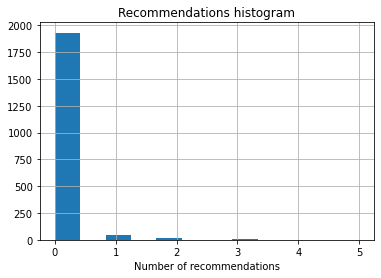

In [12]:
dfm.recommendations.hist(bins="auto");
plt.title("Recommendations histogram")
plt.xlabel("Number of recommendations")

In [13]:
Counter(dfm.recommendations)

Counter({0: 1930, 1: 46, 2: 18, 3: 5, 4: 1, 5: 2})

**Comment**

Almost everyone has 0 recommendations, only 46 have 1 recommendation and very few have more than 1. Since the platform is new is reasonable that lots of freelancers have no recommendations.

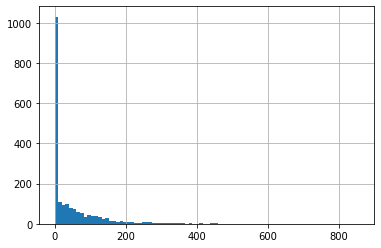

In [14]:
dfm.months_experience.hist(bins="auto");

Counter({"1 à 2 ans d'expérience": 459,
         "3 à 7 ans d'expérience": 833,
         "plus de 7 ans d'expérience": 710})

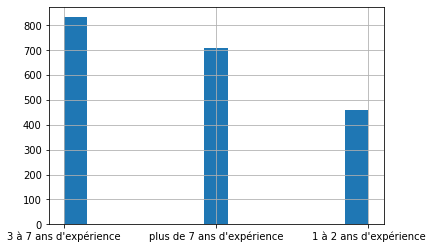

In [15]:
dfm.experience.hist(bins="auto");
Counter(dfm.experience)

**Comment** 

Here data seems to be contradictory: there are more than 1000 freelancers with 0 months of experience and only 459 with '1 à 2 ans d'expérience'. The problem is that months of experience is a feature calculated (by us) summing all the duration of the job experiences that each freelancer puts, if he wants, in his profile. While the other feature is mandatory and is requested by the platform during the subscription. 

Since is not mandatory to put all job experiences, some freelancers don't care about that, even if they have many years of experience. As result, these freelancers have no months of experience. 
In conclusion, we decide to not use this feature since is not reliable.  

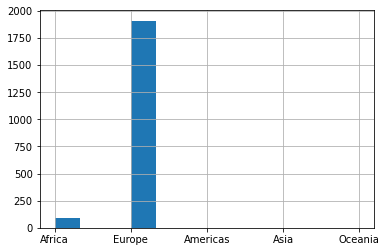

In [16]:
dfm.region.hist(bins="auto")

**Comment**

Since it's a french platform it is reasonable that almost everyone comes from Europe, only a few are African.

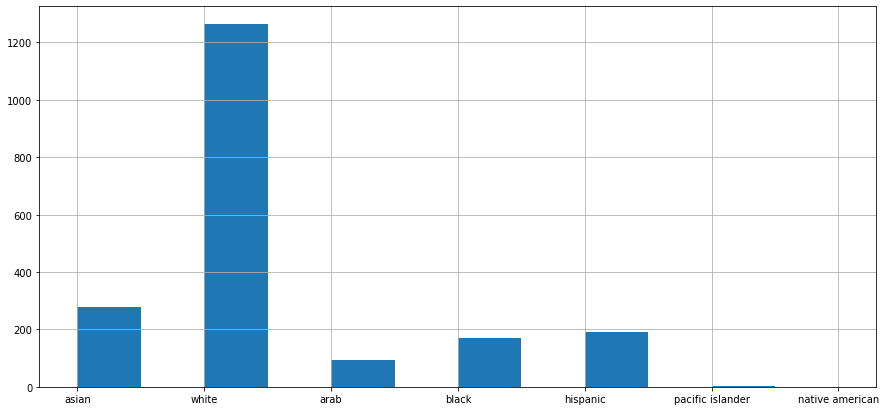

In [17]:
dfm.ethnicity.hist(bins="auto",figsize=(15,7));

**Comment** 

We have too many records for the ethnicity "pacific islander" and "native american". We remove them since it's not a sufficient representative sample.

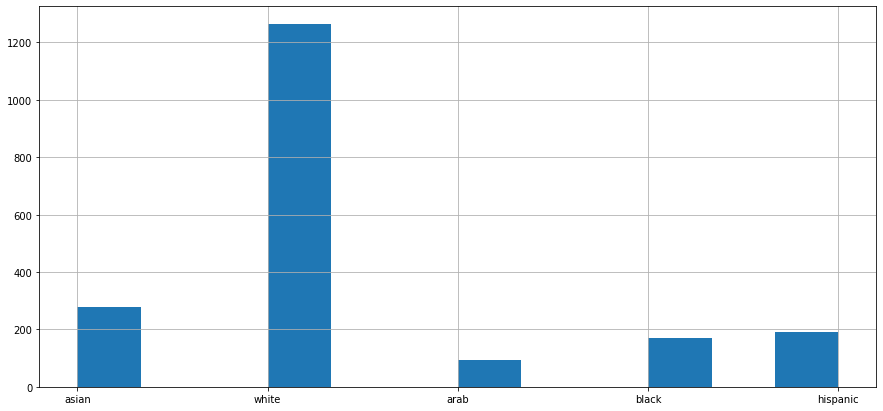

In [18]:
dfm.drop(dfm[dfm.ethnicity == "pacific islander"].index, inplace=True)
dfm.drop(dfm[dfm.ethnicity == "native american"].index, inplace=True)
dfm.ethnicity.hist(bins="auto",figsize=(15,7));

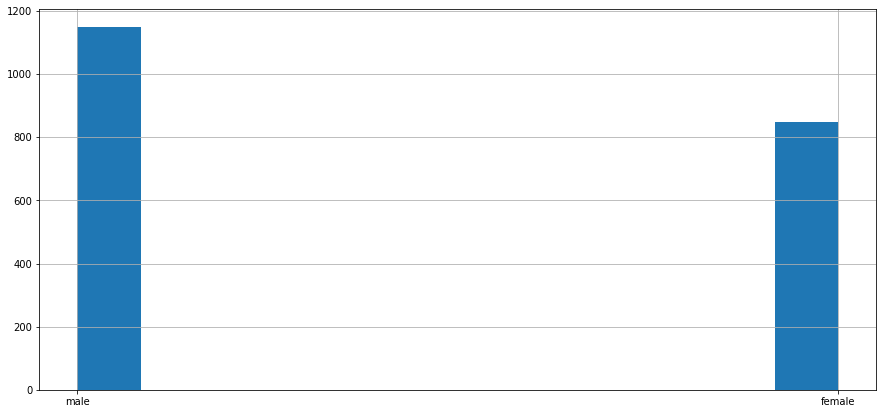

In [19]:
dfm["gender"].hist(bins="auto",figsize=(15,7));

Since tarif is a string of the following format: x€, we convert into a number using the function getSalary().

In [20]:
def getSalary(x):
  euro = x.find("€")
  return x[:euro]

dfm.tarif = dfm.tarif.apply(getSalary)
dfm.tarif = dfm.tarif.astype(int)

### Tarif per gender

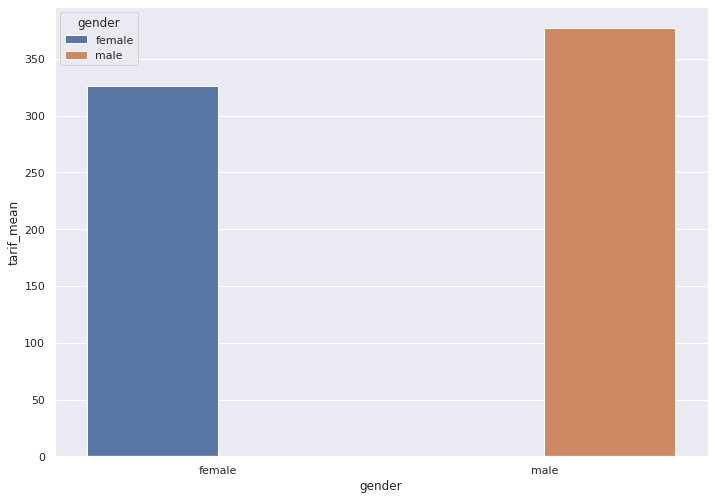

In [21]:
df = dfm
gender = []
tarif_mean = []
for k,v in df.groupby(by=["gender"]):
  gender.append(k)
  tarif_mean.append(v.tarif.mean())

data = {"gender": gender,
        "tarif_mean": tarif_mean
        }
df1 = pd.DataFrame(data)
df1.head()

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="gender", y="tarif_mean", hue="gender", data=df1)

**Comment**

From this graph, we can see that females, on average, earn a little less than males. 

### Tarif per ethnicity

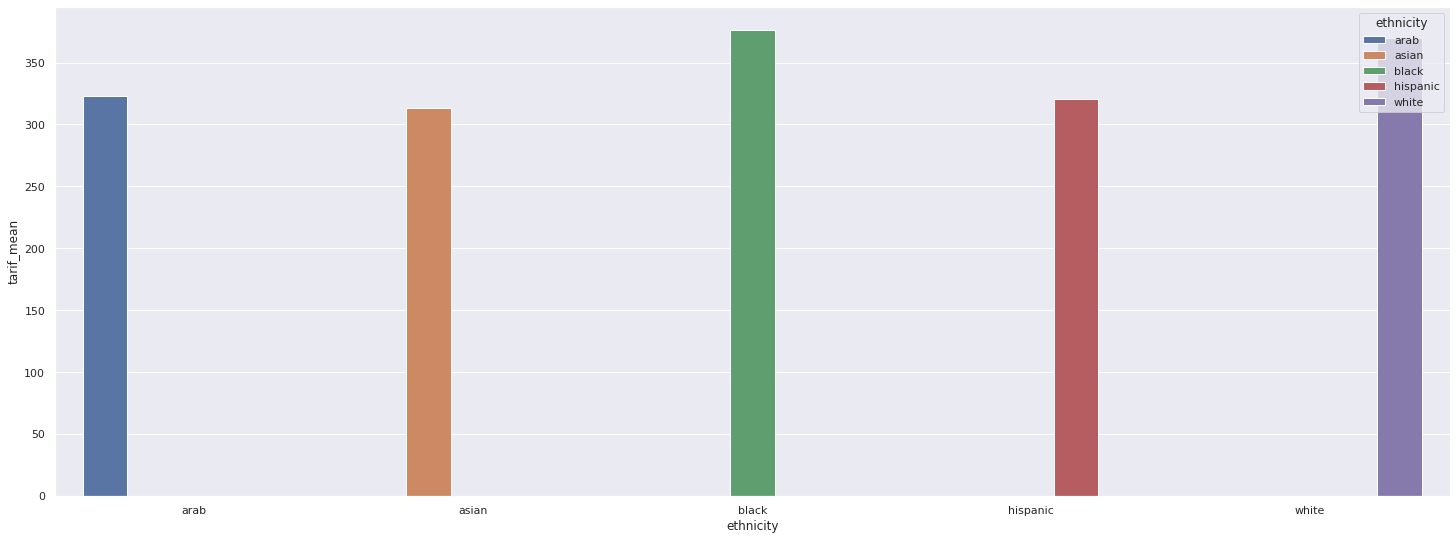

In [22]:
ethnicity = []
tarif_mean = []
for k,v in df.groupby(by=["ethnicity"]):
  ethnicity.append(k)
  tarif_mean.append(v.tarif.mean())

data = {"ethnicity": ethnicity,
        "tarif_mean": tarif_mean
        }
df2 = pd.DataFrame(data)
df2.head()


sns.set(rc={'figure.figsize':(25,9)})
ax = sns.barplot(x="ethnicity", y="tarif_mean", hue="ethnicity", data=df2)

**Comment**

We plot, for each ethnicity, the average tariff per day. Looking at this graph we can say that Hispanics and Asian earns less than the others. 

The goal is to understand why and the differences between their profiles and the other, so they can be motivated to complete their profile to provide more accurate information.

### Tarif per gender and ethnicity

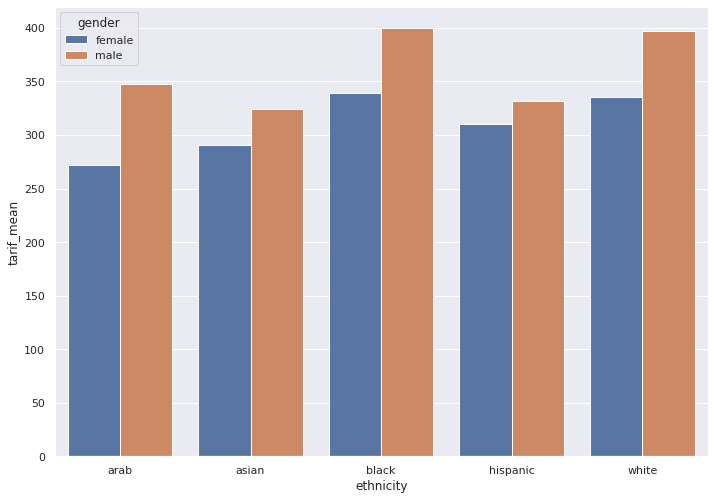

In [23]:
gender = []
ethnicity = []
tarif_mean = []
for k,v in df.groupby(by=["gender","ethnicity"]):
  gender.append(list(k)[0])
  ethnicity.append(list(k)[1])
  tarif_mean.append(v.tarif.mean())

data = {"gender": gender,
        "ethnicity": ethnicity,
        "tarif_mean": tarif_mean
        }
df1 = pd.DataFrame(data)
df1.head()


sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="ethnicity", y="tarif_mean", hue="gender", data=df1)

**Comment** 

We plot, for each ethnicity, the different tariffs per day according to gender. Again, we can see that females, on average, earn a little less than males, but this difference varies according to ethnicity.

### Tarif per job and according to ethnicity

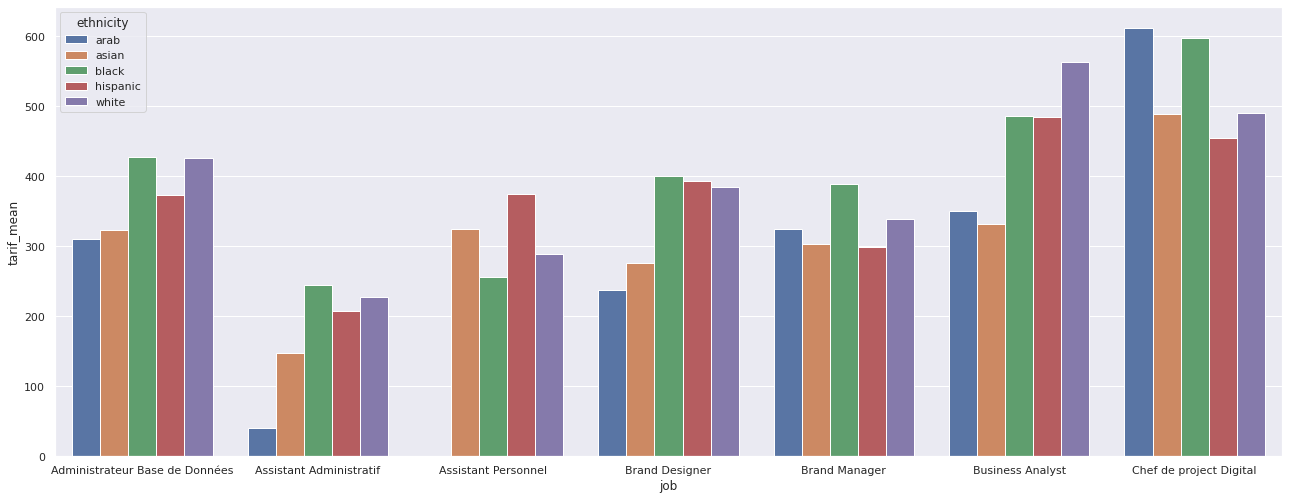

In [24]:
job = []
ethnicity = []
tarif_mean = []
for k,v in df.groupby(by=["searched_job","ethnicity"]):
  job.append(list(k)[0])
  ethnicity.append(list(k)[1])
  tarif_mean.append(v.tarif.mean())

data = {"job": job,
        "ethnicity": ethnicity,
        "tarif_mean": tarif_mean
        }
df2 = pd.DataFrame(data)

sns.set(rc={'figure.figsize':(22,8.27)})
ax = sns.barplot(x="job", y="tarif_mean", hue="ethnicity", data=df2[:34])

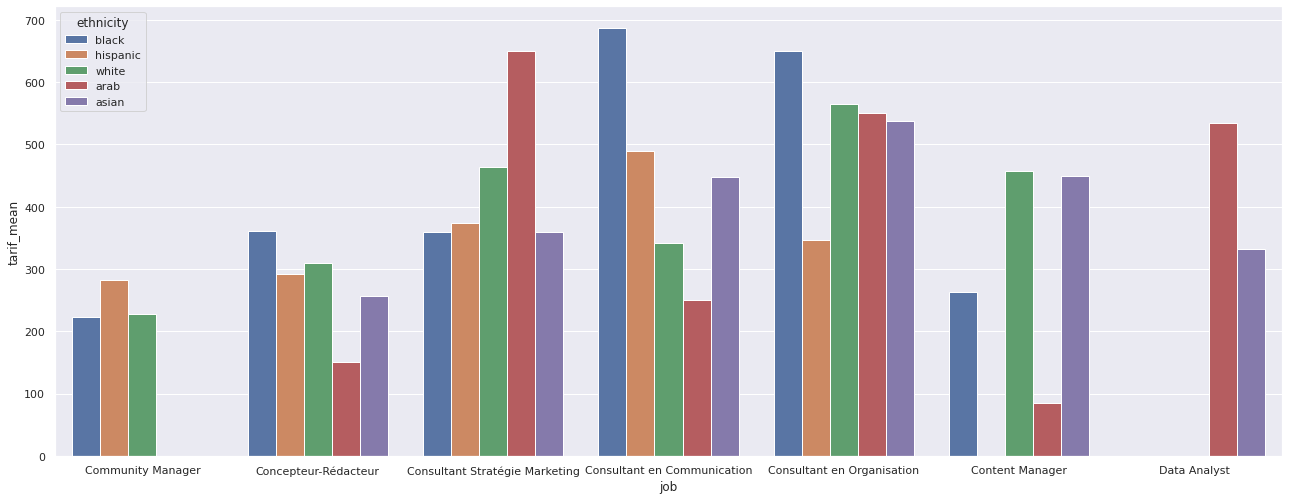

In [25]:
ax = sns.barplot(x="job", y="tarif_mean", hue="ethnicity", data=df2[35:64])

### Top25 skills in the whole platform

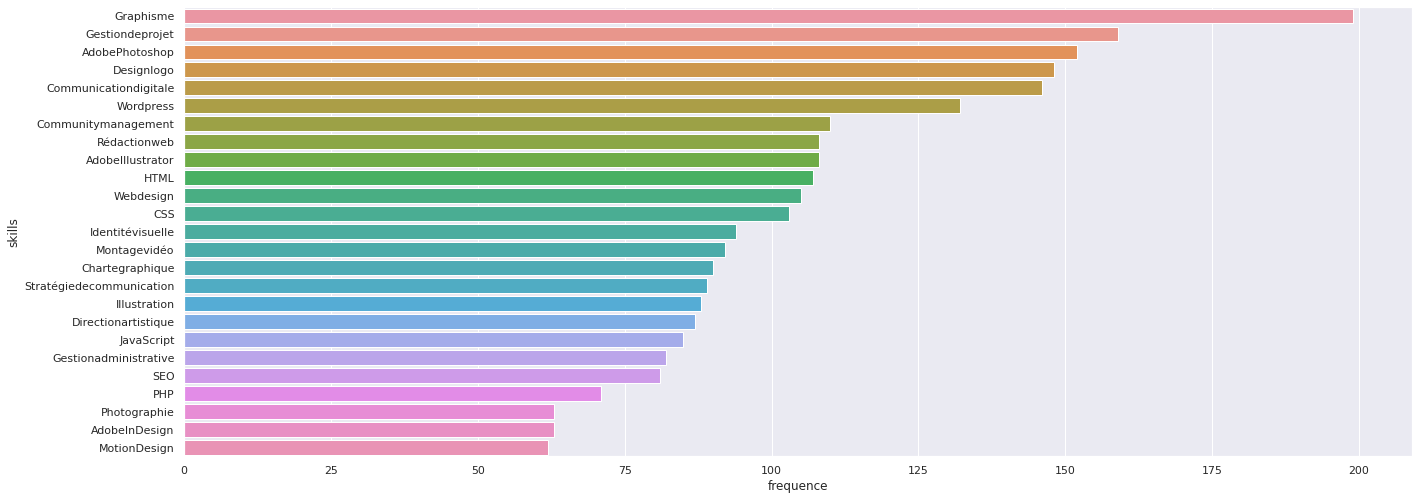

In [26]:
a = dfm.skills.apply(lambda x: x[2:-2].replace("'","").replace(" ","").split(","))

flat_list = [item for sublist in a for item in sublist]
x = Counter(flat_list)
sorted(x)
skills_freq_list = [(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)]
top25_skills = skills_freq_list[:25]

dfs = pd.DataFrame(top25_skills)
dfs = dfs.rename(columns={0: "skills", 1: "frequence"})
ax = sns.barplot(x="frequence", y="skills", data=dfs)

### Top10 skills for each different job

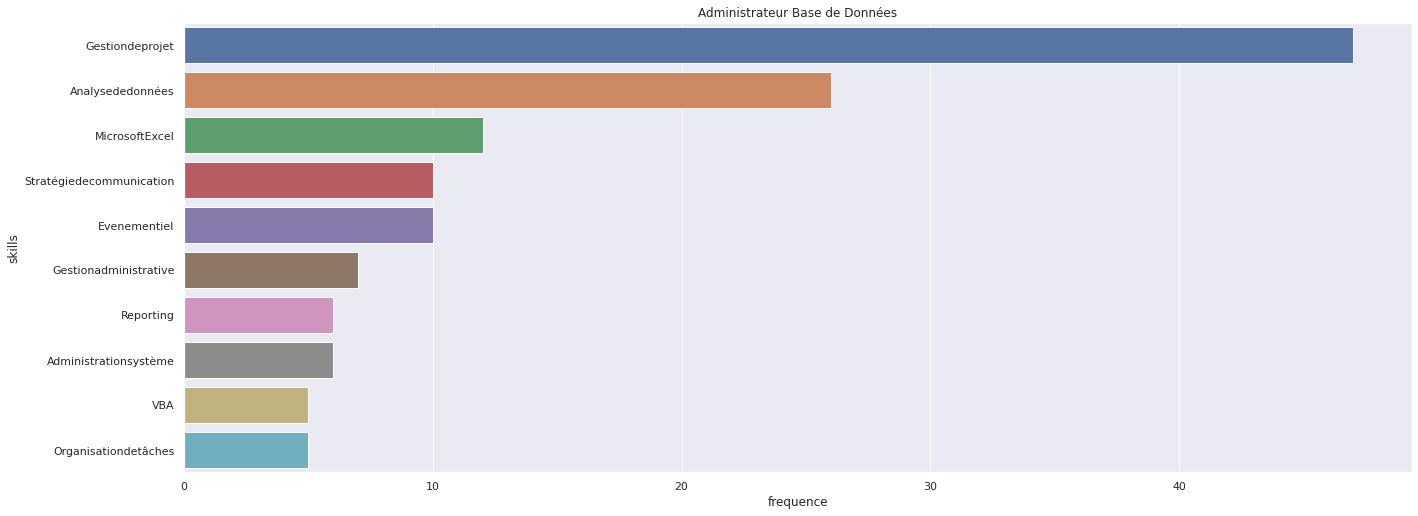

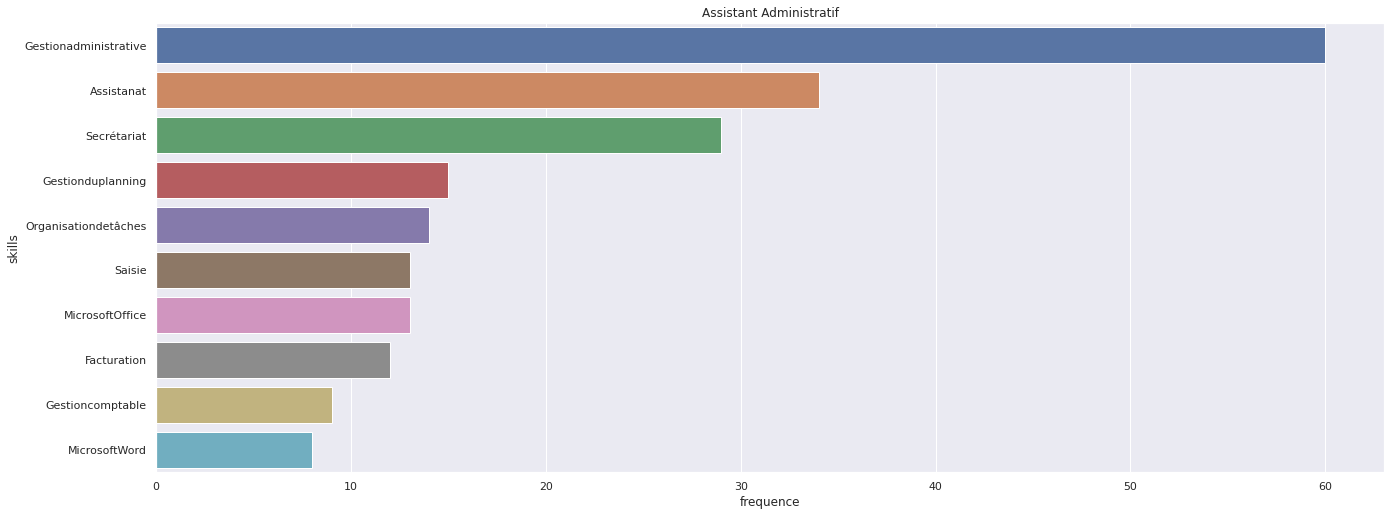

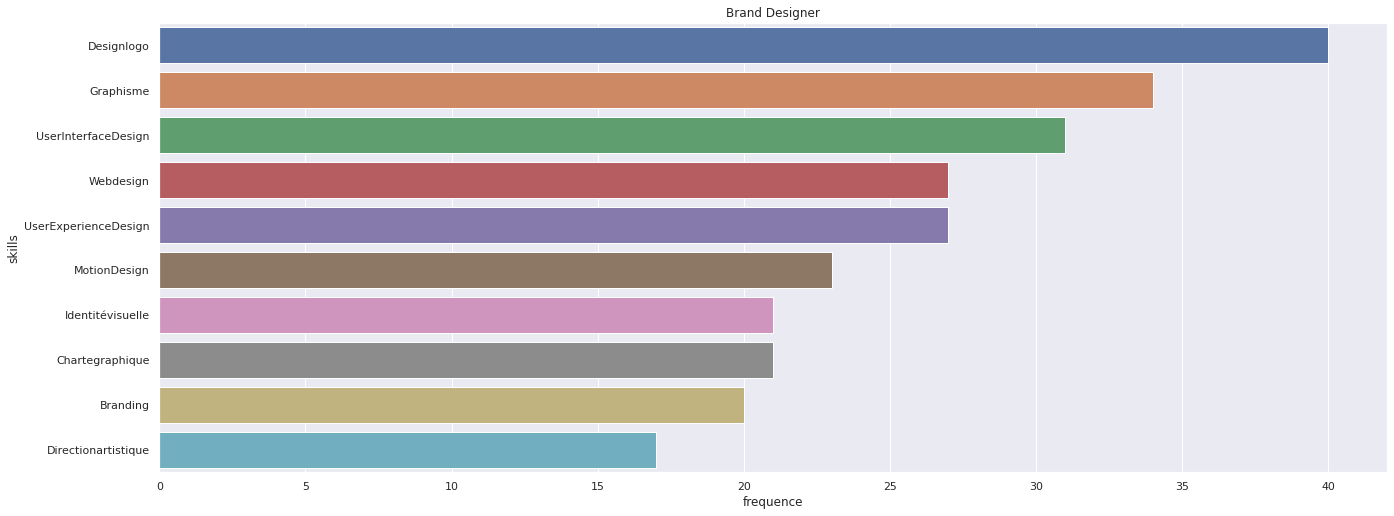

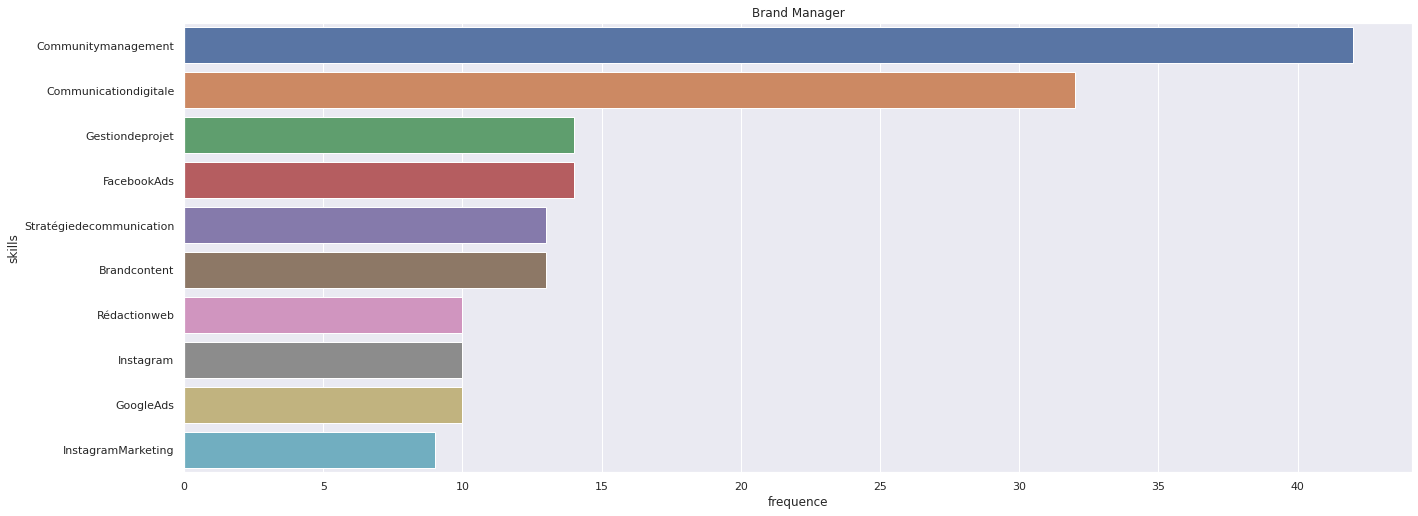

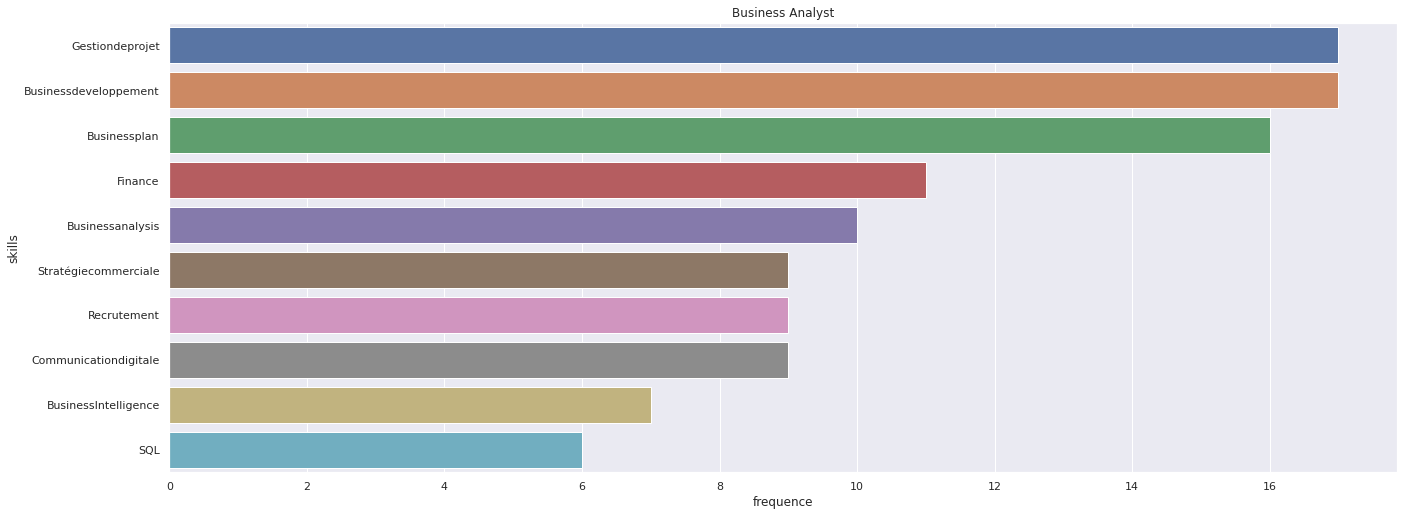

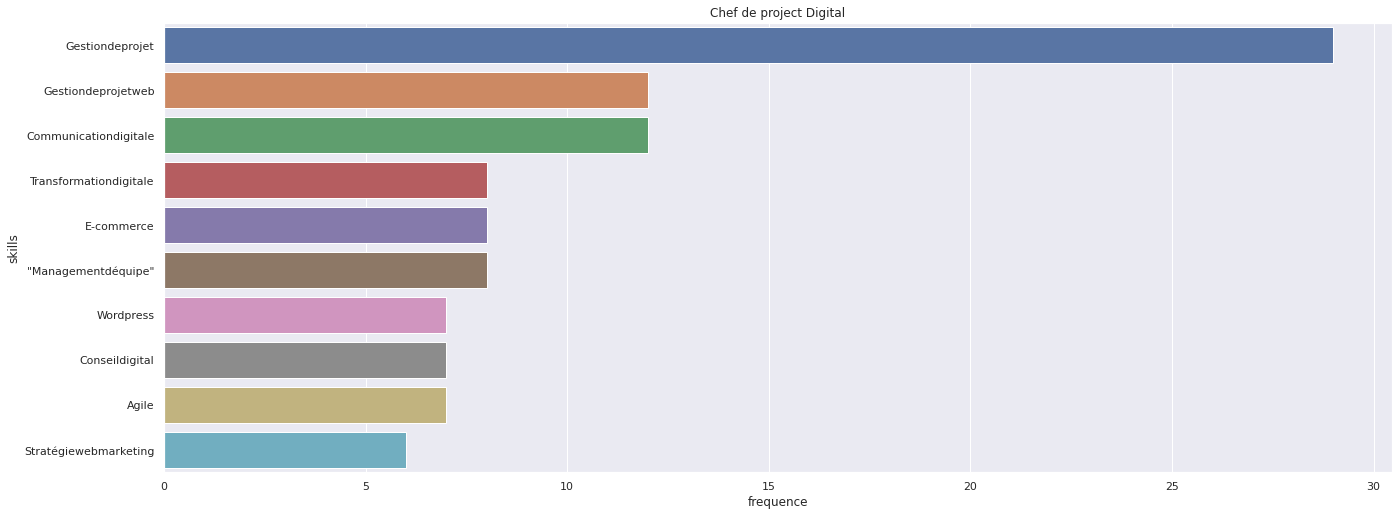

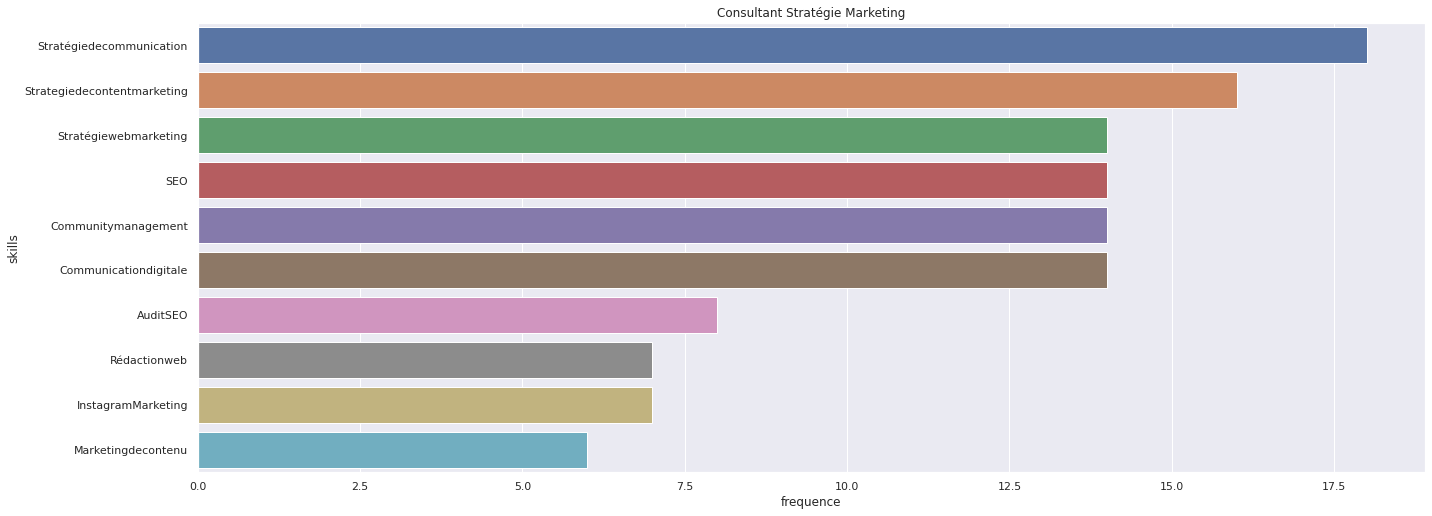

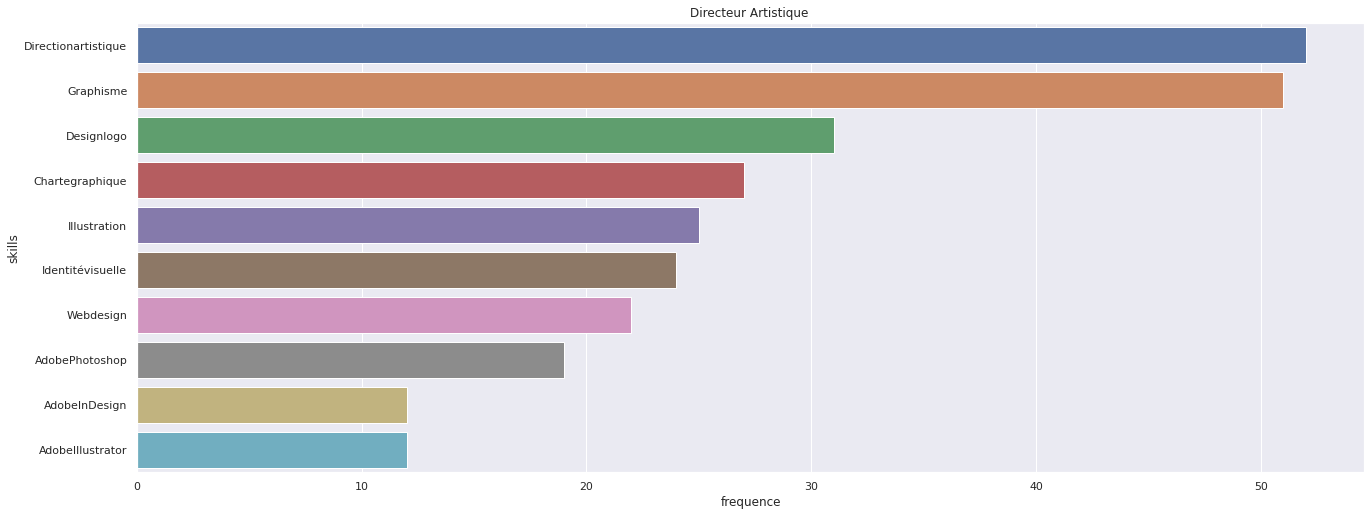

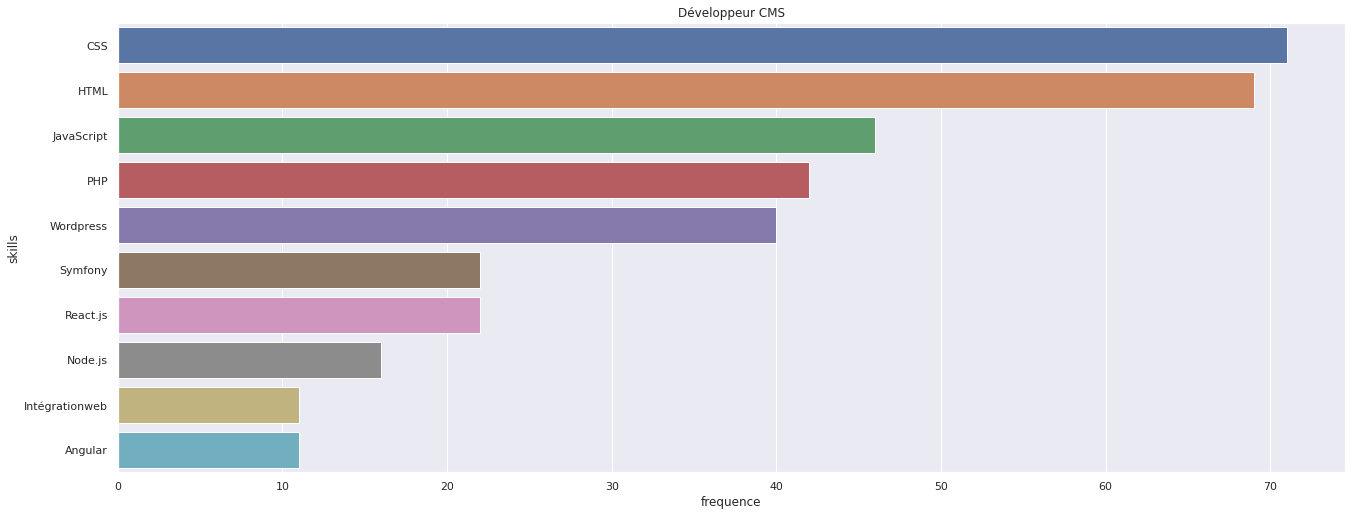

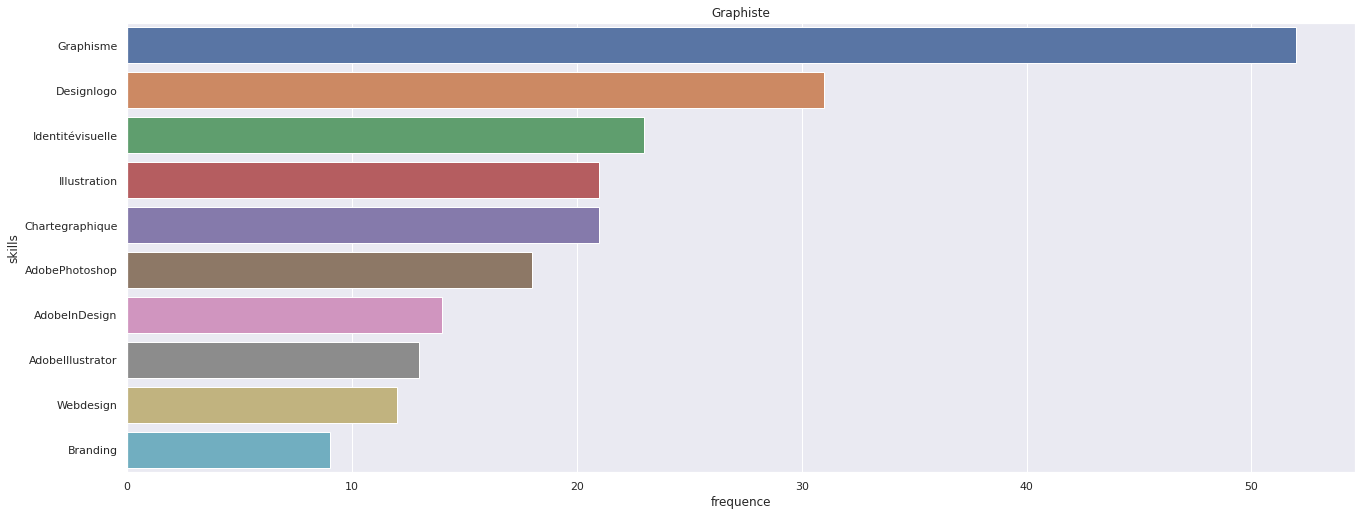

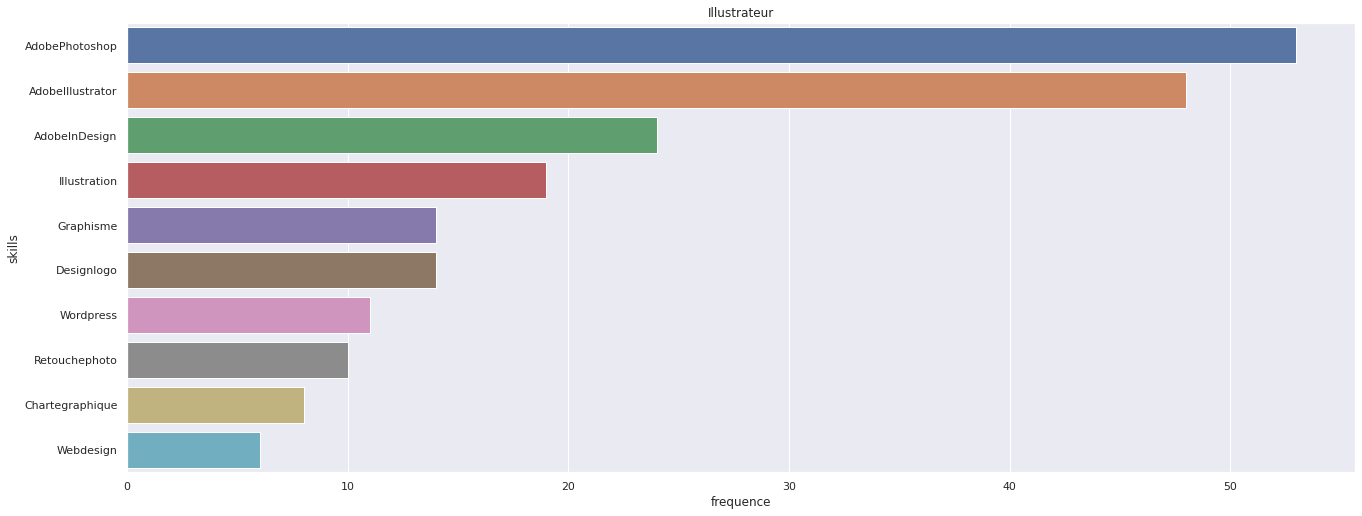

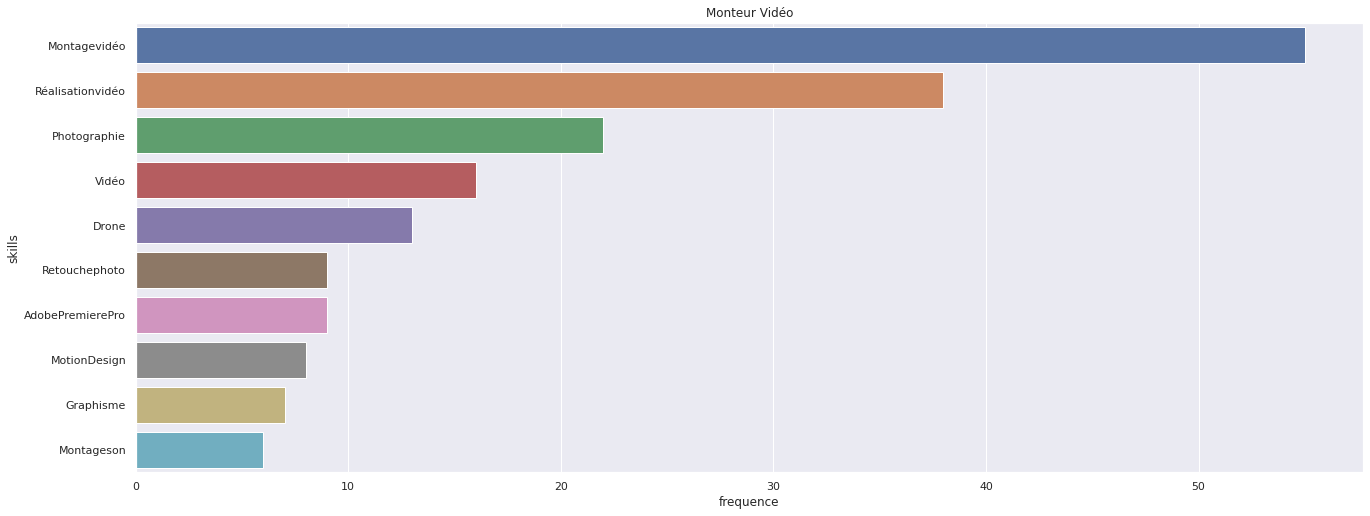

In [ ]:
i = 0
for k, v in dfm.groupby(by=["searched_job"]):
  a = v.skills.apply(lambda x: x[2:-2].replace("'","").replace(" ","").split(","))
  flat_list = [item for sublist in a for item in sublist]
  x = Counter(flat_list)
  sorted(x)
  skills_freq_list = [(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)]
  top10_skills = skills_freq_list[:10]
  dfs = pd.DataFrame(top10_skills)
  dfs = dfs.rename(columns={0: "skills", 1: "frequence"})
  if dfs.frequence.mean() > 10:
    plt.figure(i)
    plt.title(k)
    ax = sns.barplot(x="frequence", y="skills", data=dfs)
  i = i + 1

**Comment** 

For each searched job we plot the top 10 skills. Since Kamatz in a new platform, for some jobs, there are only few freelancers and so the visualization is not meaning ful. We chose only searched job with a consistent number of freelancers. To see the method see the *if condition* in the code above.

## Regression analysis

### Preprocessing

In [66]:
x = dfm[["experience","nb_skills","recommendations","months_experience","ethnicity","gender"]]

""" one hot encoder for the gender: male is our reference variable """

one_hot_gender = pd.get_dummies(x["gender"])
x = pd.concat([x,one_hot_gender], axis = 1)
x.drop(columns= ["gender","male"], inplace=True)
x.head(2)

,experience,nb_skills,recommendations,months_experience,ethnicity,female
0,3 à 7 ans d'expérience,5,0,0,asian,0
1,plus de 7 ans d'expérience,6,0,0,white,0


In [67]:
""" 
  ordinal encoder for the experience
    1 à 2 ans d'expérience: 1
    3 à 7 ans d'expérience: 2
    plus de 7 ans d'expérience: 3
"""
enc = OrdinalEncoder()
enc.fit(x[["experience"]])
x["experience"] = enc.transform(x[["experience"]])
x["experience"] = x.experience.apply(lambda x: x+1)
x.head(2)

,experience,nb_skills,recommendations,months_experience,ethnicity,female
0,2.0,5,0,0,asian,0
1,3.0,6,0,0,white,0


In [68]:
""" 
  we can remove months_experience since we already have experience. Furthermore, some freelancers have no
  months of experience because they do not write any experiences, not because they do not have. For the purpose of our
  analysis we can just use the column experience since is a more reliable information.
"""

x.drop(columns=["months_experience"], inplace=True)
x.head(2)

,experience,nb_skills,recommendations,ethnicity,female
0,2.0,5,0,asian,0
1,3.0,6,0,white,0


In [69]:
""" 
  one hot encoding for ethnicity, the reference variable is the ethnicity 'white'
"""
one_hot_ethnicity = pd.get_dummies(x["ethnicity"])
x = pd.concat([x,one_hot_ethnicity], axis = 1)
x.drop(columns=["ethnicity","white"],inplace=True)
x.head(2)

,experience,nb_skills,recommendations,female,arab,asian,black,hispanic
0,2.0,5,0,0,0,1,0,0
1,3.0,6,0,0,0,0,0,0


### Regression on the tarif

In [36]:
# dependent variable: tarif
# independent variables: experience, nb_skills, recommendations, ethnicity, gender

In [70]:
#response variable
y = dfm['tarif']
#const
const = np.ones(np.shape(y))

#variables
exp = x["experience"]
nb_skills = x["nb_skills"]
recomm = x["recommendations"]
ethn_arab = x["arab"]
ethn_asian = x["asian"]
ethn_black = x["black"]
ethn_hispanic = x["hispanic"]
gender_female = x["female"]


X = np.column_stack((const, exp, nb_skills, recomm, ethn_arab, ethn_asian, ethn_black, ethn_hispanic, gender_female))

model = sm.OLS(y,X)

In [71]:
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  tarif   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     86.46
Date:                Sat, 15 Jan 2022   Prob (F-statistic):          3.74e-123
Time:                        10:46:56   Log-Likelihood:                -13197.
No. Observations:                1997   AIC:                         2.641e+04
Df Residuals:                    1988   BIC:                         2.646e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.8397     14.250      5.953      0.0

### Regression on rank

In [72]:
# dependent variable: search rank
# independent variables: experience, nb_skills, recommendations, ethnicity, gender

In [73]:
#response variable
y = dfm["search_rank"]
#const
const = np.ones(np.shape(y))

#variables
exp = x["experience"]
nb_skills = x["nb_skills"]
recomm = x["recommendations"]
ethn_arab = x["arab"]
ethn_asian = x["asian"]
ethn_black = x["black"]
ethn_hispanic = x["hispanic"]
gender_female = x["female"]


X = np.column_stack((const, exp, nb_skills, recomm, ethn_arab, ethn_asian, ethn_black, ethn_hispanic, gender_female))

model = sm.OLS(y,X)

In [74]:
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            search_rank   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8578
Date:                Sat, 15 Jan 2022   Prob (F-statistic):              0.552
Time:                        11:17:04   Log-Likelihood:                -10347.
No. Observations:                1997   AIC:                         2.071e+04
Df Residuals:                    1988   BIC:                         2.076e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.4458      3.420     20.891      0.0